# Multi Linear Regression 
## Bike Sharing Case Study

### Problem statement
A US bike-sharing provider BoomBikes has recently suffered considerable dips in their revenues due to the ongoing Corona pandemic. The company is finding it very difficult to sustain in the current market scenario. So, it has decided to come up with a mindful business plan to be able to accelerate its revenue as soon as the ongoing lockdown comes to an end, and the economy restores to a healthy state. 

In such an attempt, BoomBikes aspires to understand the demand for shared bikes among the people after this ongoing quarantine situation ends across the nation due to Covid-19. They have planned this to prepare themselves to cater to the people's needs once the situation gets better all around and stand out from other service providers and make huge profits.

### Business goal
Modeling the **demand** for shared bikes with the available independent variables. It will be used by the management to know:
    1. Which variables are significant in predicting the demand for shared bikes.
    2. How well those variables describe the bike demands

# Import Modules

In [149]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [150]:
# Basic Python modules
import typing
from pprint import pprint


#  Import common modules for statistic
import numpy as np
import pandas as pd


# Import modules for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Import modules for machine learning
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Understanding

1. Read dataset
2. Observe summary, datatype
3. Evaluate the cleanliness of the dataset 
4. Visualized data
   1. Apply pairplot to see the relationship
   2. Apply boxplot for categorical variables

In [151]:
# Read the dataset
df = pd.read_csv("./data/bike_shareing.csv")

df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [152]:
# Re-mapping categorical variables

def map_weathersit(x: int) -> str:
    """
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    """
    if x == 1:
        return "clear"
    if x == 2:
        return "mist"
    if x == 3:
        return "light_snow"
    if x == 4:
        return "heavy"
    return x

def map_season(x: int) -> str:
    """
    - 1:spring
    - 2:summer
    - 3:fall
    - 4:winter
    """
    if x == 1:
        return "spring"
    if x == 2:
        return "summer"
    if x == 3:
        return "fall"
    if x == 4:
        return "winter"
    return x

def decode_categorical_binary_field(x: int) -> str:
    if x == 1:
        return 'yes'
    if x == 0:
        return 'no'

    return x


# convert labled 'weathersit' and 'season' feature values into categorical string values 
df["season"] = df["season"].apply(map_season)
df["weathersit"] = df["weathersit"].apply(map_weathersit)
df["yr"] = df["yr"].apply(decode_categorical_binary_field)
df["holiday"] = df["holiday"].apply(decode_categorical_binary_field)
df["workingday"] = df["workingday"].apply(decode_categorical_binary_field)


### [NEW METRICS] We transform the field dteday to create a feature
days_from_begin = dteday(i) - min(dteday) 

In [153]:
# def tranform_
df['dteday'] = pd.to_datetime(df['dteday'], format='%d-%m-%Y')
df['dteday_begin'] = pd.to_datetime(df['dteday'].min())
df['days_from_begin']  = (df['dteday'] - df['dteday_begin']) / np.timedelta64(1, 'D')

In [154]:
# Observe summary
df.dtypes

instant                     int64
dteday             datetime64[ns]
season                     object
yr                         object
mnth                        int64
holiday                    object
weekday                     int64
workingday                 object
weathersit                 object
temp                      float64
atemp                     float64
hum                       float64
windspeed                 float64
casual                      int64
registered                  int64
cnt                         int64
dteday_begin       datetime64[ns]
days_from_begin           float64
dtype: object

In [155]:
df.describe()

,instant,dteday,mnth,weekday,temp,atemp,hum,windspeed,casual,registered,cnt,dteday_begin,days_from_begin
count,730.000000,730,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730,730.000000
mean,365.500000,2018-12-31 12:00:00,6.526027,2.997260,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849,2018-01-01 00:00:00,364.500000
min,1.000000,2018-01-01 00:00:00,1.000000,0.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000,2018-01-01 00:00:00,0.000000
25%,183.250000,2018-07-02 06:00:00,4.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000,2018-01-01 00:00:00,182.250000
50%,365.500000,2018-12-31 12:00:00,7.000000,3.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000,2018-01-01 00:00:00,364.500000
75%,547.750000,2019-07-01 18:00:00,10.000000,5.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000,2018-01-01 00:00:00,546.750000
max,730.000000,2019-12-31 00:00:00,12.000000,6.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000,2018-01-01 00:00:00,729.000000
std,210.877136,NaN,3.450215,2.006161,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647,NaN,210.877136


In [156]:
df.isna().sum()

instant            0
dteday             0
season             0
yr                 0
mnth               0
holiday            0
weekday            0
workingday         0
weathersit         0
temp               0
atemp              0
hum                0
windspeed          0
casual             0
registered         0
cnt                0
dteday_begin       0
days_from_begin    0
dtype: int64

# Evaluluate the cleanliness of the dataset
- Check datatypes:
  - Datatype: All columns are in the correct datatype defined in data dictionary
  - Null: No null rows accross all columns
  - Relationship: No relationship check because we have only one dataset
  - Sanity check:
    - cnt = casual + registered
  - Non value-added columns:
    - dteday
    - instant

In [157]:
# Drop NON VALUE-ADDED columns
non_value_added_columns = ["dteday", "instant", "dteday_begin"]
for col in non_value_added_columns:
    if col in df.columns:
        df = df.drop(col, axis=1)


In [158]:
# Sanity check field cnt = casual + registered
assert len(df[df["casual"] + df["registered"] != df["cnt"]]) == 0
df.dtypes


season              object
yr                  object
mnth                 int64
holiday             object
weekday              int64
workingday          object
weathersit          object
temp               float64
atemp              float64
hum                float64
windspeed          float64
casual               int64
registered           int64
cnt                  int64
days_from_begin    float64
dtype: object

In [159]:

# Get dependent and independent variables
DEPENDENT_VARIABLES = ["casual", "registered", "cnt"]
INDEPENDENT_VARIABLES = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'days_from_begin']
assert len(DEPENDENT_VARIABLES) + len(INDEPENDENT_VARIABLES) == len(df.columns)

# Get categorical and numerical variables
CATEGORICAL_VARIABLES = ['weathersit', 'season', 'yr', 'holiday', 'workingday']
NUMERICAL_VARIABLES = ['mnth', 'weekday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt', 'days_from_begin']
assert len(CATEGORICAL_VARIABLES) + len(NUMERICAL_VARIABLES) == len(df.columns)

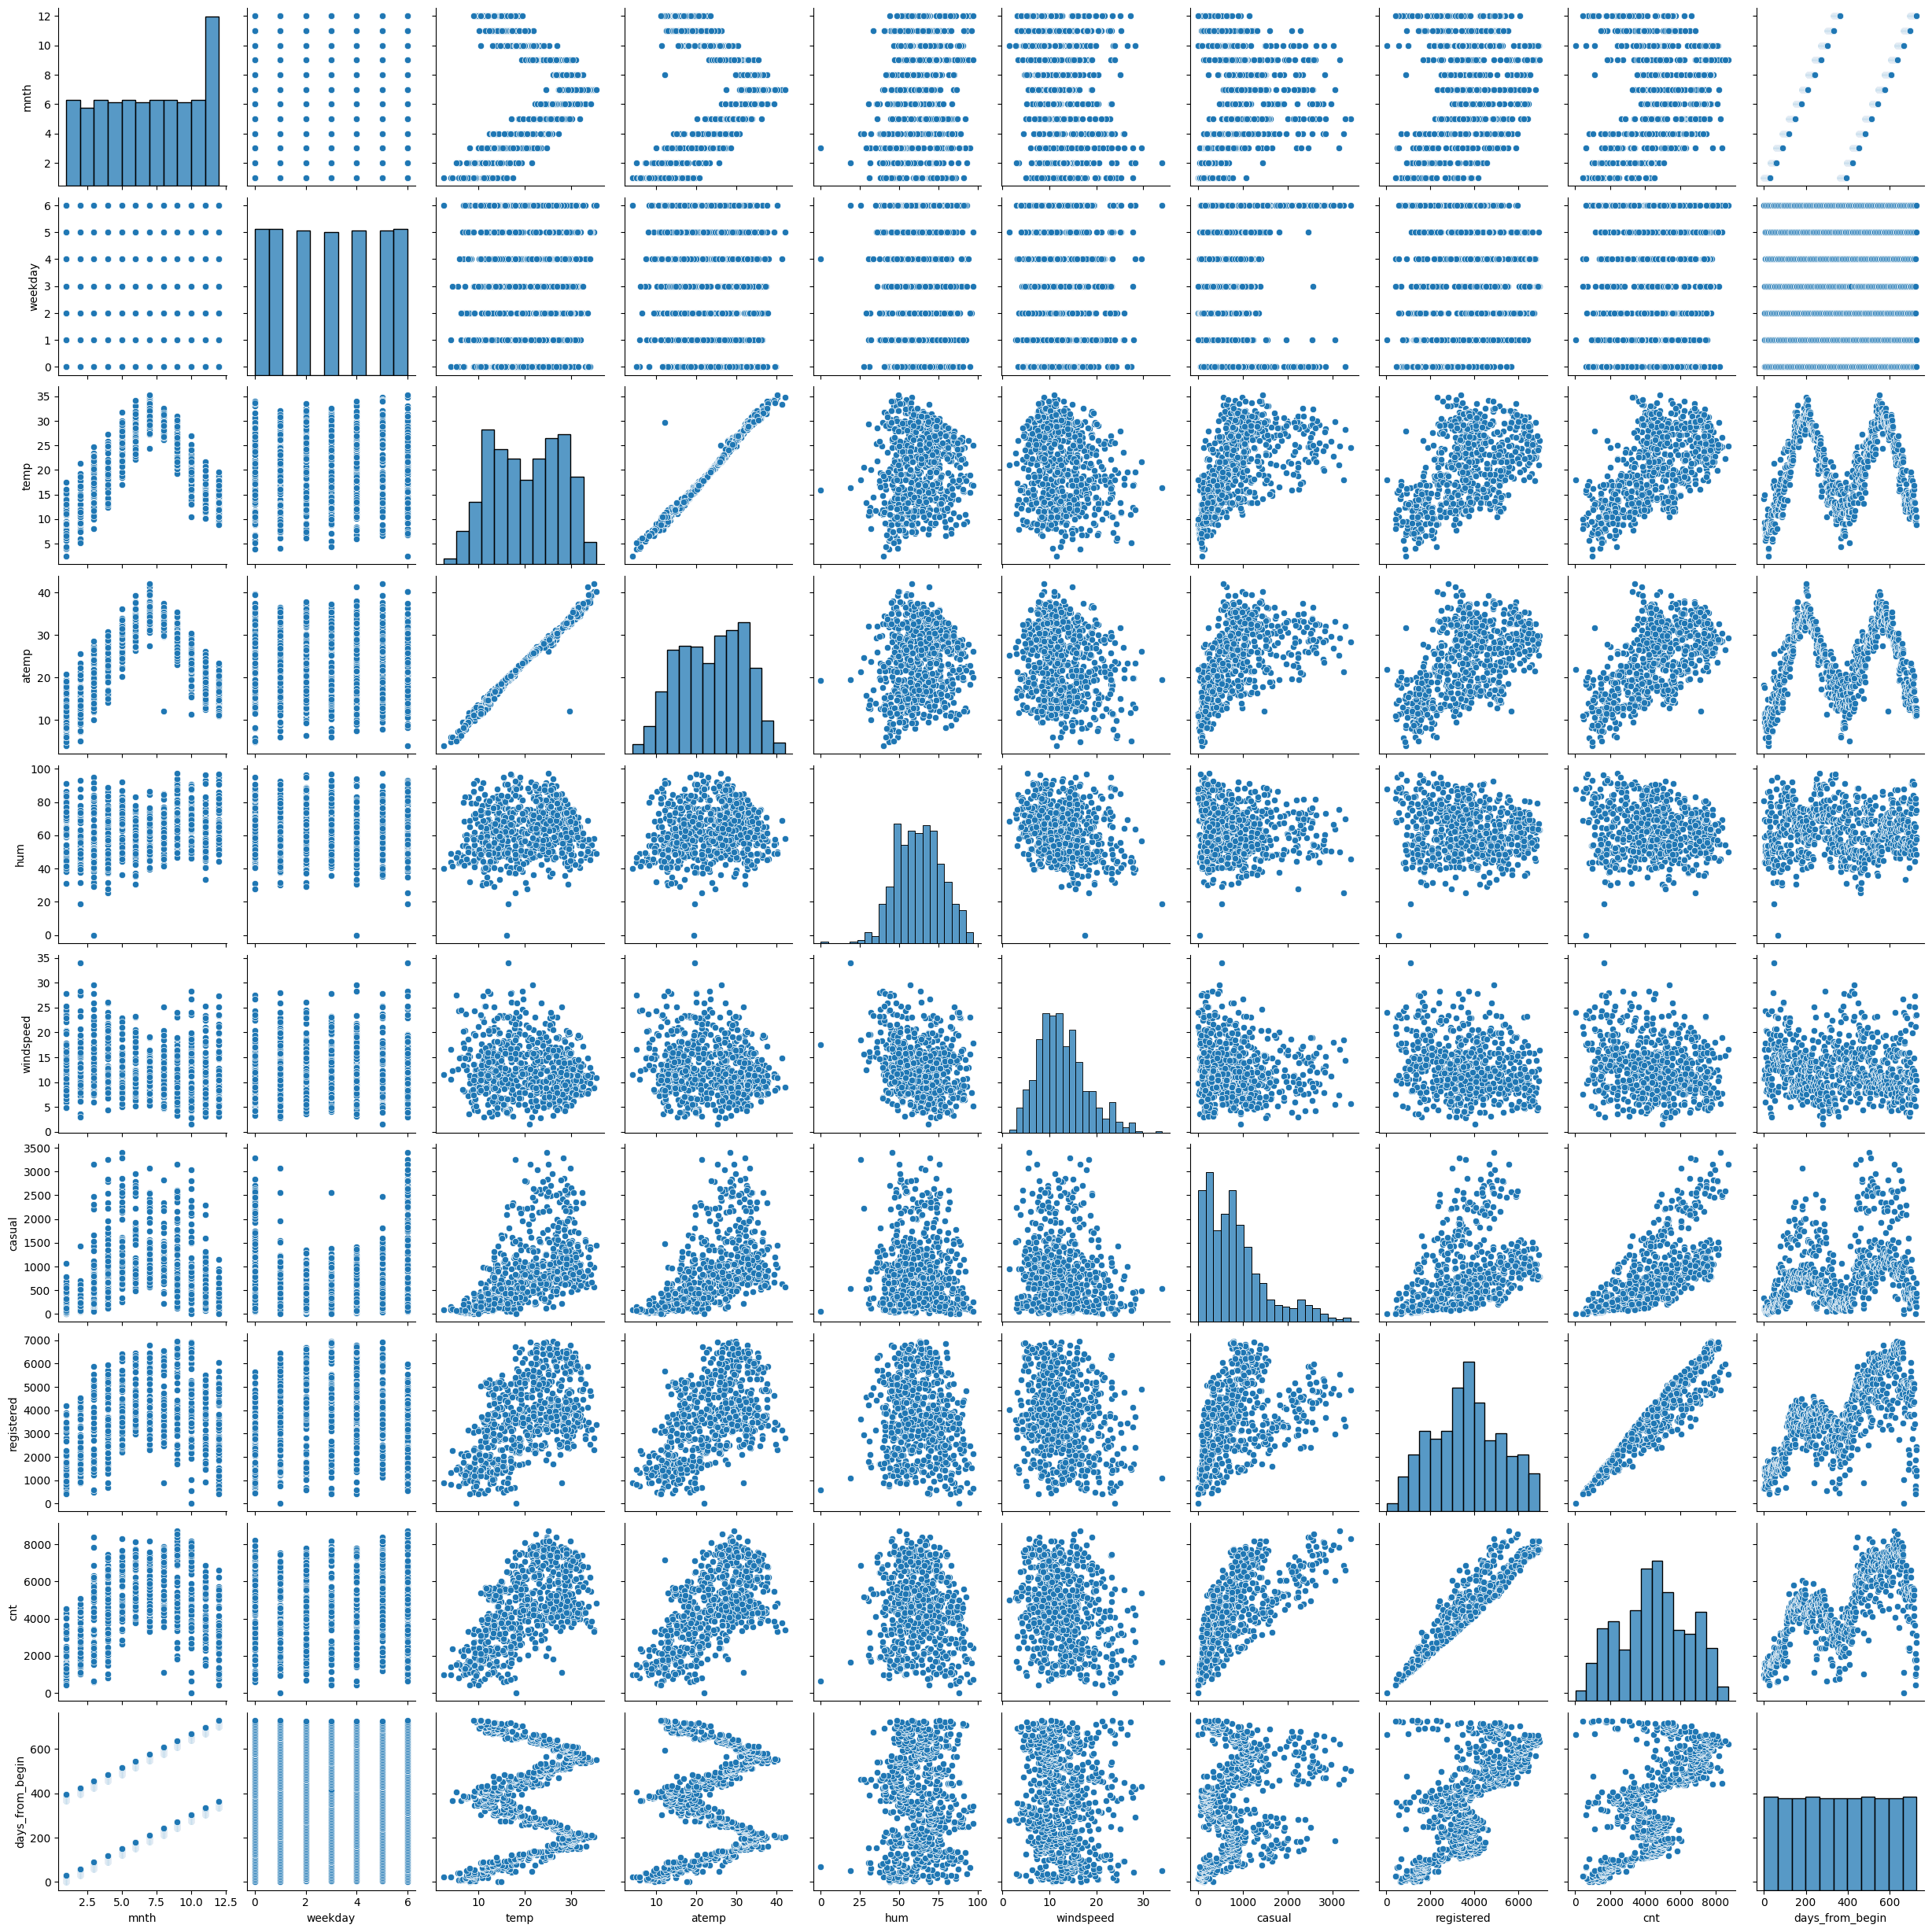

In [160]:
sns.pairplot(df)
plt.show()

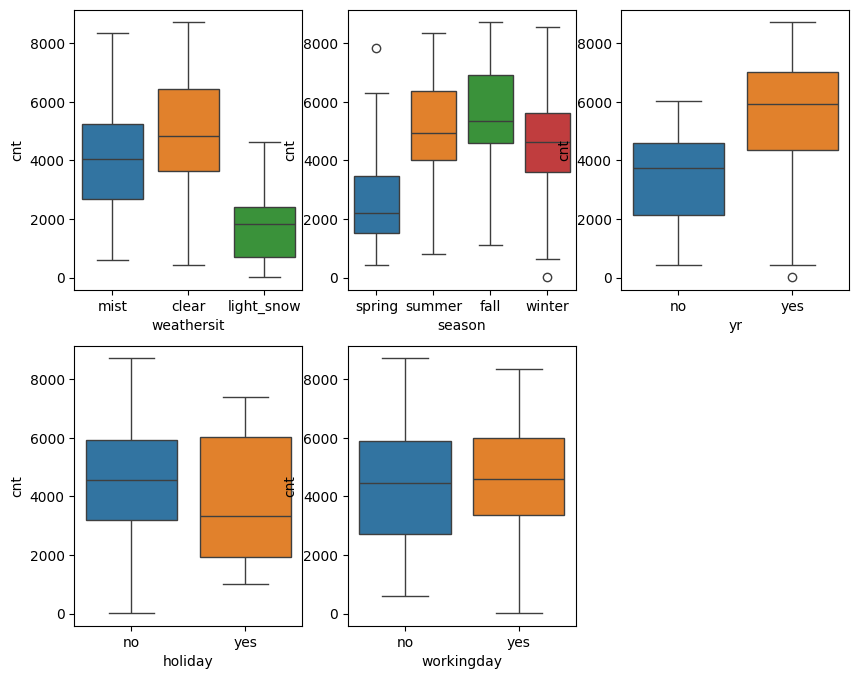

In [161]:
# Check categorical variable with cnt
plt.figure(figsize=(10, 8))
for i in range(len(CATEGORICAL_VARIABLES)):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(x=CATEGORICAL_VARIABLES[i], y="cnt", data=df, hue=CATEGORICAL_VARIABLES[i])
plt.show()

# Data Preparation
1. Transform categorical variables to numeric variables
   1. Transform binary variables to the numeric format (0,1)
   2. Transform multi-value categorical variables with dummy format
   3. Check linear regestion by pairplot
2. Split the dataset into train - test dataset
3. Rescaling numeric variable on train dataset
4. Apply heatmap to check correlation coefficients on train dataset
   1. Identify high-correlated pair
   2. Apply scatter plot the see the pattern


In [162]:
# 1.1 Transform binary categorical variable to numeric format (0, 1)
def encode_binary_categorical_variables(x: str) -> int:
    if isinstance(x, int):
        return x
    if x.lower() == 'yes':
        return 1
    if x.lower() == 'no':
        return 0
    raise ValueError(f'map_boolean_fieds func is not support value {x}')

binary_categorical_variables = ['yr', 'holiday', 'workingday']
for f in binary_categorical_variables:
    df[f] = df[f].apply(encode_binary_categorical_variables)


In [163]:
# 1.2 Transform multi-value categorical variables with dummy 
multi_values_categorical_variables = ['weathersit', 'season']
transformed_df = df.copy()
for f in multi_values_categorical_variables:
    dummy_df = pd.get_dummies(df[f], drop_first=1).astype(int)
    transformed_df = transformed_df.join(dummy_df)
    transformed_df = transformed_df.drop([f], axis=1)

In [164]:
transformed_df.head()

,yr,mnth,holiday,weekday,workingday,temp,atemp,hum,windspeed,casual,registered,cnt,days_from_begin,light_snow,mist,spring,summer,winter
0,0,1,0,6,0,14.110847,18.18125,80.5833,10.749882,331,654,985,0.0,0,1,1,0,0
1,0,1,0,0,0,14.902598,17.68695,69.6087,16.652113,131,670,801,1.0,0,1,1,0,0
2,0,1,0,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349,2.0,0,0,1,0,0
3,0,1,0,2,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562,3.0,0,0,1,0,0
4,0,1,0,3,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600,4.0,0,0,1,0,0


## Split data to train-test subset
### We will train two model
1. One model to predict cnt
2. One model to predict registerd



In [165]:
# 2. Split data to train-test subset
# We will train 2 model 
df_train, df_test = train_test_split(transformed_df, train_size=0.7, test_size=0.3, random_state=100)

In [166]:
# 3. Rescaling numeric variable on train dataset
# using nomalization scalling method
scaler = MinMaxScaler()

# Scalling train - test dataset
df_test[NUMERICAL_VARIABLES] = scaler.fit_transform(df_test[NUMERICAL_VARIABLES])
df_train[NUMERICAL_VARIABLES] = scaler.fit_transform(df_train[NUMERICAL_VARIABLES])

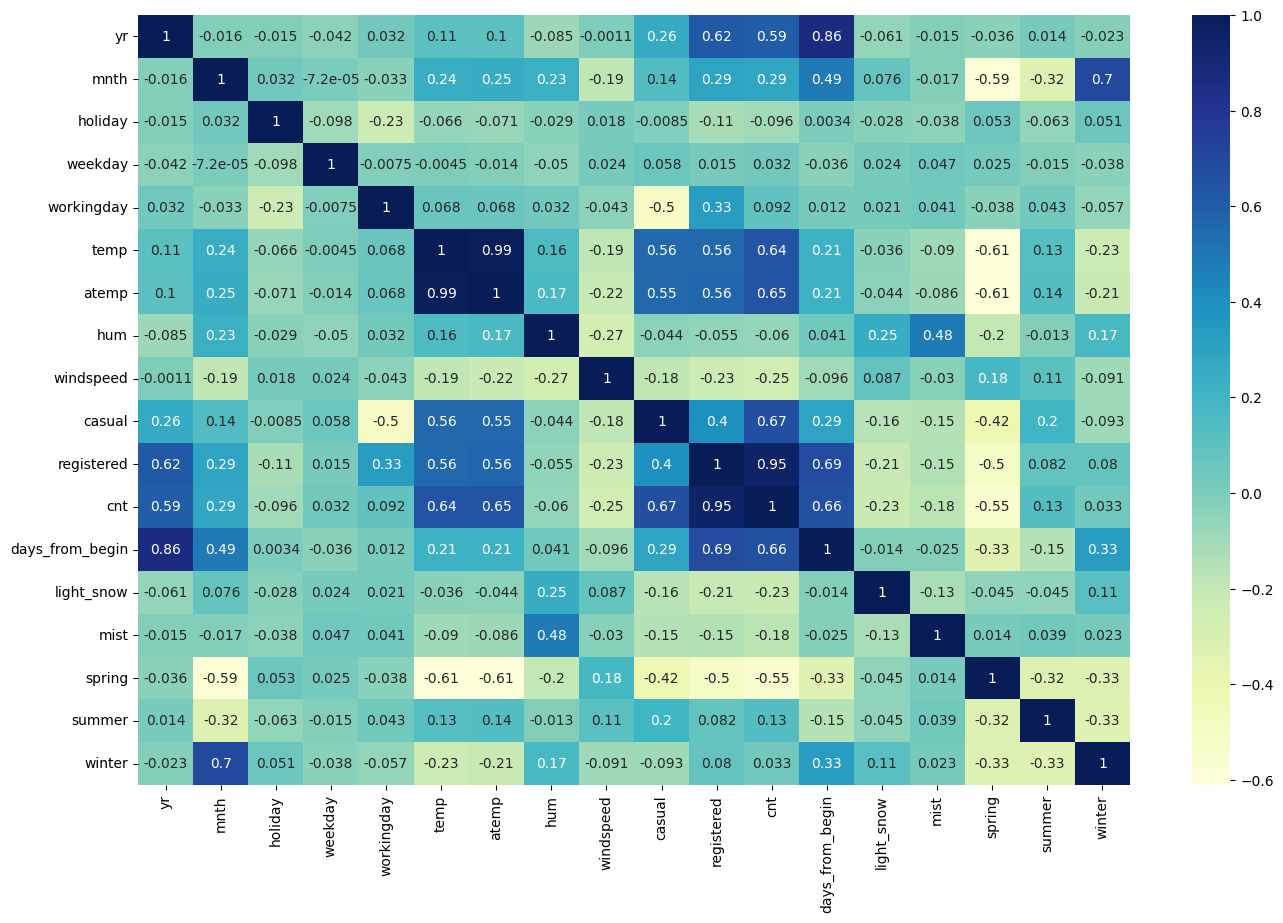

In [167]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train.corr(), annot = True, cmap="YlGnBu")
plt.show()

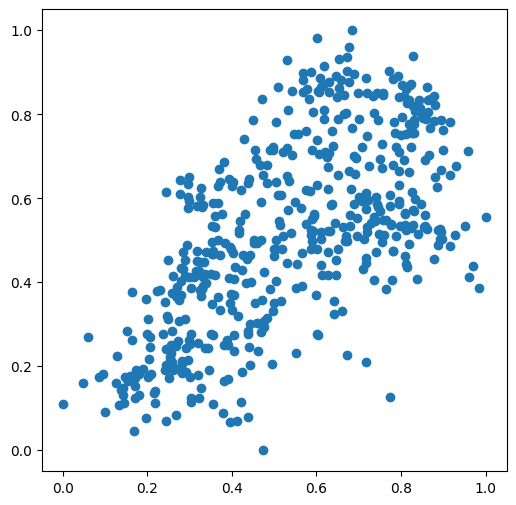

In [168]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.temp, df_train.cnt)
plt.show()

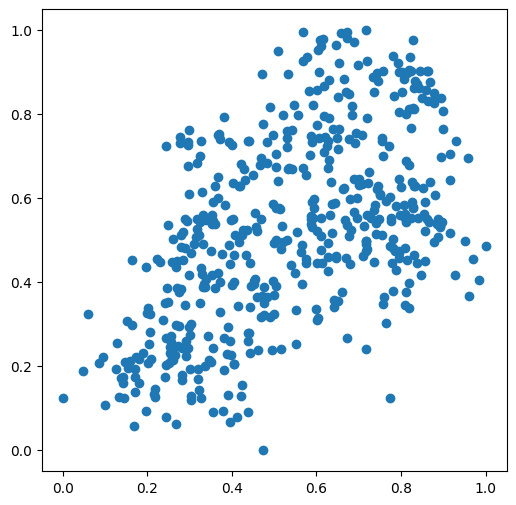

In [169]:
plt.figure(figsize=[6,6])
plt.scatter(df_train.temp, df_train.registered)
plt.show()

# Building Linear Model
- Dividing train dataset to have X and Y
- Build model and train with all fields
  -  Evaluate result by p-value and VIF
- Feature selection
  - Coarse tuning: Select top 10 features by RFE
  - Fine tuning: apply expertise and subjectivity to pick key features in the rest subset

In [170]:
class OLSModel:

    def __init__(
            self,
            model_id: str,
            X_train: pd.DataFrame,
            y_train: pd.DataFrame,
            X_test: pd.DataFrame,
            y_test: pd.DataFrame,
            model_version: str = 'v1'
            ) -> None:
        

        # Input check
        assert model_version.startswith('v'), 'model version must follow pattern v<version>'
        
        # User-input attributes
        self.id = model_id
        self.version = model_version
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test

        # Run-time attribute
        self.vif = self.calculate_vif(self.X_train)
        self.y_predict = None
        self.model: sm.OLS = None

    @property
    def name(self) -> str:
        return '{}_{}'.format(self.id, self.version)

    def predict(self, sm_dataset: pd.DataFrame) -> pd.DataFrame:
        """
            Do prediction with current model
            :param sm_dataset: input dataframe which added constant
            :return prediction result
        """

        if self.model is None:
            raise NotImplementedError("Model hasn't trained yet.")
        
        return self.model.predict(sm_dataset)

    def train(self) -> None:
        """
        Initialize a LR Model and fit dataset into
        return: Fit model
        """
        X_train_lm = sm.add_constant(self.X_train)

        self.model = sm.OLS(self.y_train, X_train_lm).fit()

    def test(self) -> None:
        """
            Run test model
            
        """
        X_test_sm = sm.add_constant(self.X_test)

        self.y_predict = self.predict(X_test_sm)

        print("y_predict is set")
        
    @staticmethod
    def auto_select_features(
        algorithm: str,
        X: pd.DataFrame,
        y: pd.DataFrame,
        n_features_to_select: int = 10,
        ) -> dict:
        """
        Run feature selection by a specific algorithm
        """

        result = {
            'ranking': None,
            'columns': None
        }

        if algorithm == 'rfe':
            
            lm = LinearRegression()
            lm.fit(X, y)

            rfe = RFE(lm, n_features_to_select=n_features_to_select)     
            rfe = rfe.fit(X, y)

            result['ranking'] = list(zip(X.columns, rfe.support_,rfe.ranking_))
            result['columns'] = rfe.support_
        else:
            return ValueError("Feature selection algorithm hasn't supported yet.")
        
        return result
        
    @staticmethod
    def calculate_vif(X_train: pd.DataFrame) -> pd.DataFrame:
        """
        Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model.
        VIF_i = 1 / (1 - R_i^2)
        """
        vif = pd.DataFrame()
        vif['Features'] = X_train.columns
        vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
        vif['VIF'] = round(vif['VIF'], 2)
        vif = vif.sort_values(by = "VIF", ascending = False)
        return vif

    def residual_analyze(self) -> None:

        if self.model is None:
            raise NotImplementedError("Model hasn't trained yet.")
        
        result =  {
            'vif': self.vif,
            'model_params':  self.model.params,
            'model_summary': self.model.summary(),
        }

        for k, v in result.items():
            print(f'========================= {k} =========================')
            pprint(v)
    
    def show_evaluation(self) -> None:
        """
        Visualize the relationship of prediction result with test dataset
        """

        fig = plt.figure()
        plt.scatter(self.y_test, self.y_predict)
        fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
        plt.xlabel('y_test', fontsize = 18)                          # X-label
        plt.ylabel('y_pred', fontsize = 16) 
        plt.show()

    def show_error(self) -> None:
        fig = plt.figure()
        sns.distplot((self.y_test - self.y_predict), bins = 20)
        fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
        plt.xlabel('Errors', fontsize = 18)   
        

## Building ML model to predict CNT

###  Train model to predict cnt value
- We will remove 2 variable casual and registered because cnt = casual + registered

========================= vif =========================
           Features      VIF
9   days_from_begin  2245.65
0                yr   852.11
1              mnth   513.08
5              temp   380.54
6             atemp   367.67
7               hum    31.13
8         windspeed     5.05
14           winter     4.66
12           spring     4.52
4        workingday     3.21
3           weekday     3.18
13           summer     2.72
11             mist     2.36
10       light_snow     1.26
2           holiday     1.11
========================= model_params =========================
const              0.243659
yr                 0.329122
mnth               0.101075
holiday           -0.063953
weekday            0.048632
workingday         0.019008
temp               0.438252
atemp              0.056223
hum               -0.124440
windspeed         -0.177652
days_from_begin   -0.193245
light_snow        -0.248345
mist              -0.058811
spring            -0.070853
summer             0.04

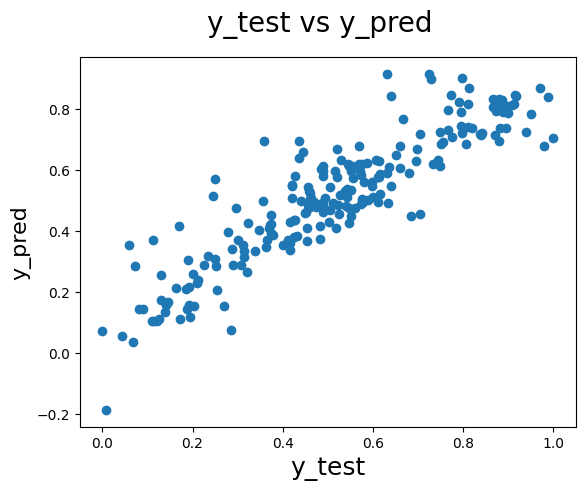

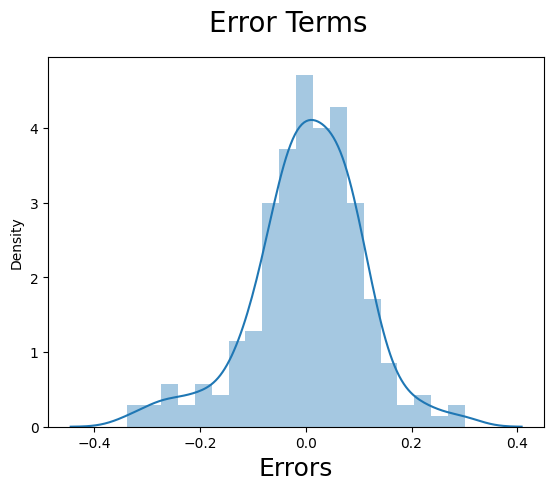

In [171]:
target_variable = 'cnt'

# Some fields have relationship with target variable will be deleted at the begining
# cnt = registered + casual
# temp is high correlate with atemp
init_drop_variables = ['registered', 'casual']

# Remove registered casual to avoid bias
cnt_train_df = df_train.drop(init_drop_variables, axis=1)
cnt_test_df = df_test.drop(init_drop_variables, axis=1)


# Diving train dataset to have X and Y
cnt_y_train = cnt_train_df.pop(target_variable)
cnt_X_train = cnt_train_df

# Diving test dataset to have X and Y
cnt_y_test = cnt_test_df.pop(target_variable)
cnt_X_test = cnt_test_df[cnt_X_train.columns]


# Select top 10 the most important features by RFE algorithm

features = OLSModel.auto_select_features(
    algorithm='rfe', 
    X=cnt_X_train, 
    y=cnt_y_train, 
    n_features_to_select=10
    )

# Build model with all fields
cnt_model_v1 = OLSModel(
    model_id='bike_sharing_cnt_predictor',
    X_train=cnt_X_train,
    y_train=cnt_y_train,
    X_test=cnt_X_test,
    y_test=cnt_y_test,
    model_version='v1'
)

cnt_model_v1.train()

cnt_model_v1.residual_analyze()

cnt_model_v1.test()

cnt_model_v1.show_evaluation()

cnt_model_v1.show_error()


### Model tunning
1. Both RFE and the statistic result show that we should remove field "mnth"
We see "mnth" has high p-value (0.626) and low VIF (12.53) -> remove first
2. atemp field have the high VIF and following the correlation diagram we see this value has tight relationship with temp -> redudant we can remove

========================= vif =========================
      Features    VIF
5          hum  27.38
4         temp  15.70
6    windspeed   4.69
9       spring   3.90
3   workingday   3.19
2      weekday   3.11
11      winter   3.11
8         mist   2.28
10      summer   2.27
0           yr   2.08
7   light_snow   1.24
1      holiday   1.10
========================= model_params =========================
const         0.245913
yr            0.231926
holiday      -0.064169
weekday       0.048642
workingday    0.018698
temp          0.493356
hum          -0.123498
windspeed    -0.180002
light_snow   -0.249333
mist         -0.058608
spring       -0.074200
summer        0.043376
winter        0.090437
dtype: float64
========================= model_summary =========================
<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model: 

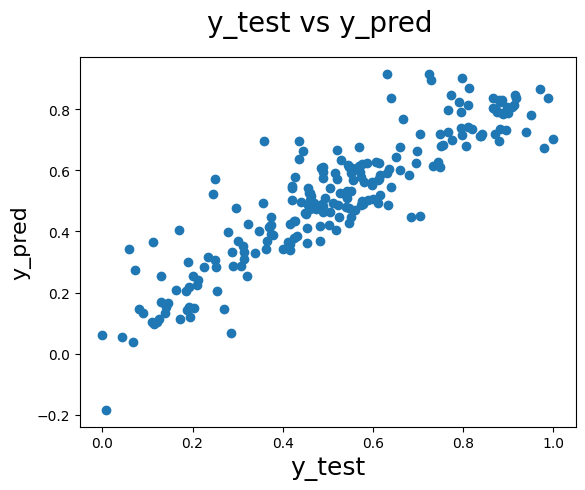

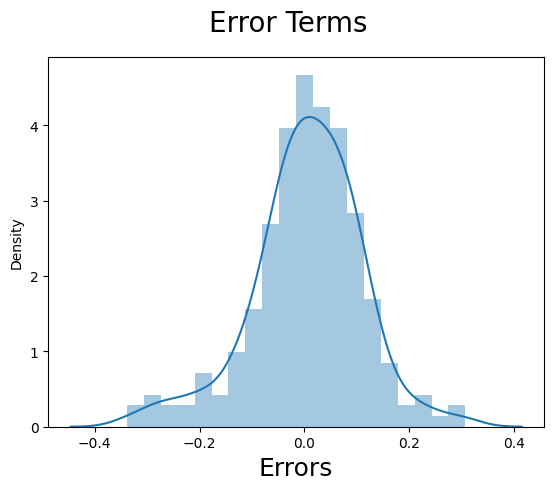

In [172]:
target_variable = 'cnt'

# Some fields have relationship with target variable will be deleted at the begining
# cnt = registered + casual
# temp is high correlate with atemp
init_drop_variables = ['registered', 'casual', 'mnth', 'atemp', 'days_from_begin']

# Remove registered casual to avoid bias
cnt_train_df = df_train.drop(init_drop_variables, axis=1)
cnt_test_df = df_test.drop(init_drop_variables, axis=1)


# Diving train dataset to have X and Y
cnt_y_train = cnt_train_df.pop(target_variable)
cnt_X_train = cnt_train_df

# Diving test dataset to have X and Y
cnt_y_test = cnt_test_df.pop(target_variable)
cnt_X_test = cnt_test_df[cnt_X_train.columns]


# Select top 10 the most important features by RFE algorithm

features = OLSModel.auto_select_features(
    algorithm='rfe', 
    X=cnt_X_train, 
    y=cnt_y_train, 
    n_features_to_select=10
    )

# Build model with all fields
cnt_model_v2 = OLSModel(
    model_id='bike_sharing_cnt_predictor',
    X_train=cnt_X_train,
    y_train=cnt_y_train,
    X_test=cnt_X_test,
    y_test=cnt_y_test,
    model_version='v2'
)

cnt_model_v2.train()

cnt_model_v2.residual_analyze()

cnt_model_v2.test()

cnt_model_v2.show_evaluation()

cnt_model_v2.show_error()



###  Train model to predict registerd value

{'ranking': [('yr', True, 1), ('mnth', False, 7), ('holiday', False, 10), ('weekday', False, 9), ('workingday', False, 3), ('temp', False, 4), ('atemp', True, 1), ('hum', True, 1), ('windspeed', True, 1), ('days_from_begin', False, 6), ('light_snow', True, 1), ('mist', False, 8), ('spring', False, 2), ('summer', False, 11), ('winter', False, 5)], 'columns': array([ True, False, False, False, False, False,  True,  True,  True,
       False,  True, False, False, False, False])}
========================= vif =========================
           Features      VIF
9   days_from_begin  2245.65
0                yr   852.11
1              mnth   513.08
5              temp   380.54
6             atemp   367.67
7               hum    31.13
8         windspeed     5.05
14           winter     4.66
12           spring     4.52
4        workingday     3.21
3           weekday     3.18
13           summer     2.72
11             mist     2.36
10       light_snow     1.26
2           holiday     1.11

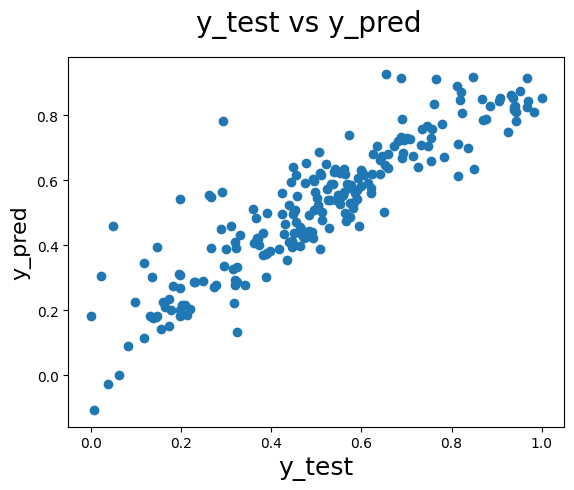

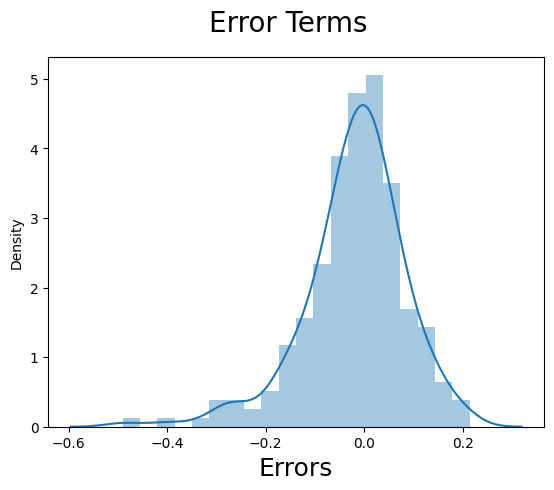

In [173]:
target_variable = 'registered'

# Some fields have relationship with target variable will be deleted at the begining
init_drop_variables = ["cnt" , 'casual']

# Remove registered casual to avoid bias
registered_train_df = df_train.drop(init_drop_variables, axis=1)


# Diving train dataset to have X and Y
registered_y_train = registered_train_df.pop(target_variable)
registered_X_train = registered_train_df

# Diving test dataset to have X and Y
registered_test_df = df_test.drop(init_drop_variables, axis=1)


# Scaling numerical variables
registered_y_test = registered_test_df.pop(target_variable)
registered_X_test = registered_test_df[registered_X_train.columns]


# Select 5 the most important features
features = OLSModel.auto_select_features(
    algorithm='rfe', 
    X=registered_X_train, 
    y=registered_y_train, 
    n_features_to_select=5
    )

print(features)

# Build model with all fields
registered_model_v1 = OLSModel(
    model_id='bike_sharing_registered_predictor',
    X_train=registered_X_train,
    y_train=registered_y_train,
    X_test=registered_X_test,
    y_test=registered_y_test,
    model_version='v1'
)

registered_model_v1.train()

registered_model_v1.residual_analyze()

registered_model_v1.test()

registered_model_v1.show_evaluation()

registered_model_v1.show_error()


## Tunning Registerd Model
- Remove field atemp

{'ranking': [('yr', True, 1), ('workingday', False, 3), ('temp', True, 1), ('hum', True, 1), ('windspeed', True, 1), ('light_snow', True, 1), ('mist', False, 5), ('spring', False, 2), ('winter', False, 4)], 'columns': array([ True, False,  True,  True,  True,  True, False, False, False])}
========================= vif =========================
     Features    VIF
3         hum  22.11
2        temp  13.19
4   windspeed   3.96
1  workingday   3.01
7      spring   2.52
6        mist   2.22
8      winter   2.08
0          yr   2.06
5  light_snow   1.20
========================= model_params =========================
const         0.244019
yr            0.249986
workingday    0.143688
temp          0.379132
hum          -0.110302
windspeed    -0.145820
light_snow   -0.250961
mist         -0.054862
spring       -0.100398
winter        0.085161
dtype: float64
========================= model_summary =========================
<class 'statsmodels.iolib.summary.Summary'>
"""
                    

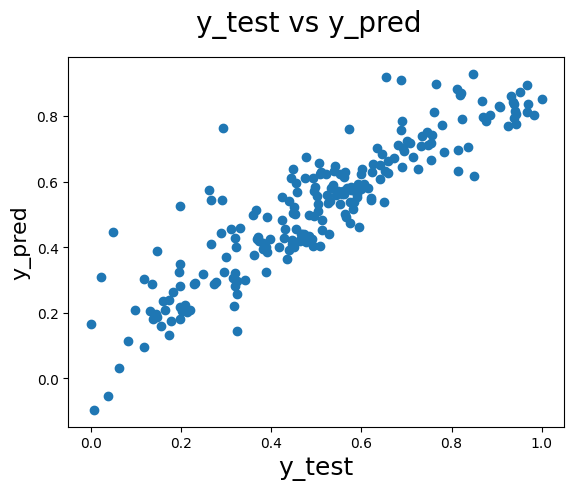

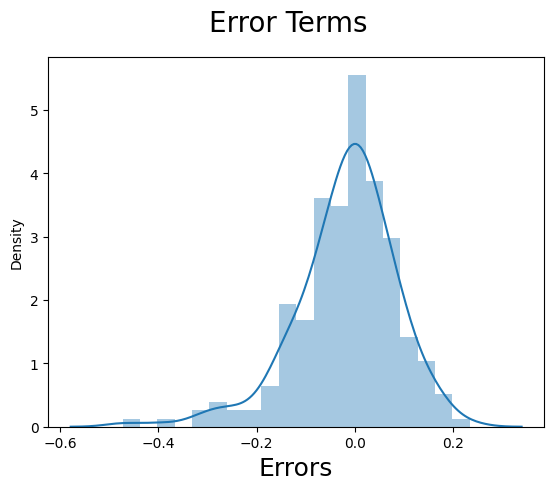

In [174]:
target_variable = 'registered'

# Some fields have relationship with target variable will be deleted at the begining
init_drop_variables = ["cnt" , 'casual', 'atemp', 'holiday', 'summer', 'days_from_begin', 'mnth', 'weekday']

# Remove registered casual to avoid bias
registered_train_df = df_train.drop(init_drop_variables, axis=1)


# Diving train dataset to have X and Y
registered_y_train = registered_train_df.pop(target_variable)
registered_X_train = registered_train_df

# Diving test dataset to have X and Y
registered_test_df = df_test.drop(init_drop_variables, axis=1)


# Scaling numerical variables
registered_y_test = registered_test_df.pop(target_variable)
registered_X_test = registered_test_df[registered_X_train.columns]


# Select 5 the most important features
features = OLSModel.auto_select_features(
    algorithm='rfe', 
    X=registered_X_train, 
    y=registered_y_train, 
    n_features_to_select=5
    )

print(features)

# Build model with all fields
registered_model_v2 = OLSModel(
    model_id='bike_sharing_registered_predictor',
    X_train=registered_X_train,
    y_train=registered_y_train,
    X_test=registered_X_test,
    y_test=registered_y_test,
    model_version='v2'
)

registered_model_v2.train()

registered_model_v2.residual_analyze()

registered_model_v2.test()

registered_model_v2.show_evaluation()

registered_model_v2.show_error()